### 【PaddleMIX】基于Qwen2VL的图像描述快速体验

#### 1. 模型介绍

##### 1.1 介绍

Qwen2-VL系列是对Qwen-VL模型的改进升级，重新定义了传统的预设分辨率方法在视觉处理中的应用。Qwen2-VL引入了原生动态分辨率机制，使得模型能够动态地将不同分辨率的图像处理成不同数量的视觉tokens。该方法能够生成更高效、准确的视觉表征，更贴近人类的感知过程。模型还集成了多模态旋转位置嵌入（M-RoPE），促进了文本、图像和视频之间位置信息的有效融合。Qwen2-VL系列采用了统一的图像和视频处理范式，提升了模型的视觉感知能力。

<img src="https://github.com/user-attachments/assets/e4b09c13-89d0-46a9-9d95-6f1fff98c753" width="60%" alt="Qwen2-VL示例图">

如上图所示，在模型能力上Qwen2-VL能够实现多语种图像文本理解、代码/数学推理、视频分析、直播聊天、智能体等。


##### 1.2 方法
<img src="https://github.com/user-attachments/assets/18fe9fb3-9117-423d-97ee-b28eb0770732" width="60%" alt="Qwen2-VL模型图">

如上图，整体上Qwen2-VL仍然延续了 Qwen-VL 中 ViT 加 Qwen2 的串联结构，在三个不同尺度的模型上，Qwen2-VL 都采用 600M 规模大小的 ViT，并且支持图像和视频统一输入。为了让模型更清楚地感知视觉信息和理解视频，Qwen2-VL 还进行了以下升级：
* **原生动态分辨率**：Qwen2-VL 在架构上的一大改进是实现了对原生动态分辨率的全面支持。与上一代模型相比，Qwen2-VL 能够处理任意分辨率的图像输入，不同大小图片被转换为动态数量的 tokens，最小只占 4 个 tokens。这种设计不仅确保了模型输入与图像原始信息之间的高度一致性，更是模拟了人类视觉感知的自然方式，赋予模型处理任意尺寸图像的强大能力，使其在图像处理领域展现出更加灵活和高效的表现。具体而言，为了减少每个图像的视觉令tokens，Qwen2-VL 在ViT之后使用一个简单的MLP层将相邻的2 × 2 tokens压缩为单个token，并将特殊的<|vision_start|>和<|vision_end|> token放置在压缩的视觉tokens的开始和结束处。因此，分辨率为224 × 224的图像，使用patch_size = 14的ViT编码，在进入LLM之前，将被压缩到66个tokens。
* **多模态旋转位置嵌入（M-ROPE）**：Qwen2-VL 在架构上的另一重要创新则是多模态旋转位置嵌入（M-ROPE）。传统的旋转位置嵌入只能捕捉一维序列的位置信息，而 M-ROPE 通过将原始旋转嵌入分解为代表时间、高度和宽度的三个部分，使得大规模语言模型能够同时捕捉和整合一维文本序列、二维视觉图像以及三维视频的位置信息。这一创新赋予了语言模型强大的多模态处理和推理能力，能够更好地理解和建模复杂的多模态数据。
* **统一图像和视频理解**：Qwen2-VL采用图像和视频数据混合的训练方案，保证了图像理解和视频理解的充分性。为了尽可能完整地保留视频信息，Qwen2-VL以每秒两帧的速度对每个视频进行采样。此外，Qwen2-VL集成了深度为2的3D卷积来处理视频输入，使模型能够处理3D管道而不是2D补丁，从而使其能够在不增加序列长度的情况下处理更多的视频帧。为了保持一致，每幅图像被视为两个相同的帧。为了平衡长视频处理的计算需求和整体训练效率，Qwen2-VL 动态调整每个视频帧的分辨率，将每个视频的tokens总数限制为16384个。这种训练方式在模型对长视频的理解能力和训练效率之间取得了平衡。


#### 2.环境配置
#### 模型fp16精度推理的显存开销，如果使用Qwen2-VL-72B模型，需要使用4卡40以上显存的GPU

| 模型                     | 图像理解显存占用|
|-------------------------|----------------|
| Qwen/Qwen2-VL-2B-Instruct|  12G       |      
| Qwen/Qwen2-VL-7B-Instruct|    22G       |      
| Qwen/Qwen2-VL-72B-Instruct|      4*42G       |         

In [2]:
# 下载PaddleMIX代码库
!git clone --depth=1 https://github.com/PaddlePaddle/PaddleMIX.git

Cloning into 'PaddleMIX'...
remote: Enumerating objects: 3156, done.
remote: Counting objects: 100% (3156/3156), done.
remote: Compressing objects: 100% (2112/2112), done.
remote: Total 3156 (delta 1024), reused 2468 (delta 947), pack-reused 0 (from 0)
Receiving objects: 100% (3156/3156), 131.96 MiB | 15.89 MiB/s, done.
Resolving deltas: 100% (1024/1024), done.


In [5]:
%%capture
# 安装依赖
%cd /home/aistudio/PaddleMIX
!pip install -e . --user
!pip install -e ppdiffusers --user
!pip install -r requirements.txt --user
!pip install -r pillow tqdm paddlenlp==3.0.0b3 --user

# 安装好后重启内核

### 3. 图像描述快速体验

In [1]:
import paddle

from paddlemix.models.qwen2_vl import MIXQwen2Tokenizer
from paddlemix.models.qwen2_vl.modeling_qwen2_vl import Qwen2VLForConditionalGeneration
from paddlemix.processors.qwen2_vl_processing import (
    Qwen2VLImageProcessor,
    Qwen2VLProcessor,
    process_vision_info,
)
from paddlemix.utils.log import logger

/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/paddle/utils/cpp_extension/extension_utils.py:686: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/_distutils_hack/__init__.py:31: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
[

import module error: fast_ln
import module error: fused_ln
Warning, FusedLn module is not available, use LayerNorm instead.
Warning, FusedLn module is not available, use LayerNorm instead.


[2025-02-24 11:24:25,592] [ WARNING] moe_lm.py:454 - `grouped_gemm` is not installed, using sequential GEMM, which is slower.


modeling_internlm2 has_flash_attn is True.
modeling_intern_vit has_flash_attn is True.


In [ ]:
# 下载模型权重，定义模型
model_path = "Qwen/Qwen2-VL-2B-Instruct" #入门推荐使用2B模型，7B加载模型需等待较长时间
# model_path = "Qwen/Qwen2-VL-7B-Instruct"
model = Qwen2VLForConditionalGeneration.from_pretrained(model_path, dtype="float16")
image_processor = Qwen2VLImageProcessor()
tokenizer = MIXQwen2Tokenizer.from_pretrained(model_path)
processor = Qwen2VLProcessor(image_processor, tokenizer)

# 推理大图时，若显存不够，可以传入max_pixels参数
# min_pixels = 256*28*28 # 200704
# max_pixels = 1280*28*28 # 1003520
# processor = Qwen2VLProcessor(image_processor, tokenizer, min_pixels=min_pixels, max_pixels=max_pixels)

In [4]:
def visualize_image(image_path):
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img = mpimg.imread(image_path)
    plt.figure(figsize=(4, 3))  # 例如 4x3 英寸
    plt.imshow(img)
    plt.axis('off')  # 不显示坐标轴
    plt.show()

In [5]:
def definite_messages(image_file, prompt):
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": f"{image_file}",
                },
                {"type": "text", "text": f"{prompt}"},
            ],
        }
    ]
    return messages

In [6]:
# 模型推理
def model_inference(messages, max_new_tokens=512, temperature=0.6, top_p=0.8):
    image_inputs, video_inputs = process_vision_info(messages)
    text = [processor.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)]

    inputs = processor(
        text=text,
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pd",
    )
    generated_ids = model.generate(
        **inputs, max_new_tokens=max_new_tokens, temperature=temperature, top_p=top_p
    )  
    output_text = processor.batch_decode(
        generated_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return output_text

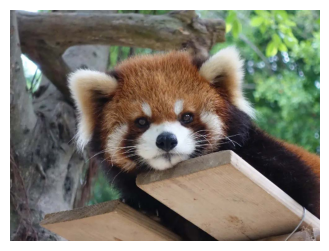

In [6]:
image_file = "PaddleMIX/paddlemix/demo_images/examples_image1.jpg"
prompt = "Describe this image."

visualize_image(image_file)

messages = definite_messages(image_file, prompt)



In [7]:
output_text = model_inference(messages)
print("output_text:\n", output_text[0])

W0224 11:30:49.564378 45809 multiply_fwd_func.cc:76] got different data type, run type promotion automatically, this may cause data type been changed.


output_text:
 The image depicts a red panda, also known as a lesser panda or a small panda, which is a type of mammal native to the mountainous regions of China, Nepal, Bhutan, and India. The red panda is characterized by its reddish-brown fur with white markings on its face, ears, and chest. Its eyes are dark brown, and it has a small, rounded head with large, expressive eyes that give it a somewhat endearing appearance.

In the image, the red panda is positioned in what appears to be an enclosure or habitat designed for it. The background shows a natural setting with trees and green foliage, indicating that the enclosure is likely part of a zoo or wildlife sanctuary. The red panda is leaning over a wooden structure, possibly a feeding platform or a resting area, which is constructed from light-colored wood. The structure has a flat surface and is supported by a wooden frame, suggesting it is designed to provide a comfortable space for the animal.

The red panda's fur is dense and app

In [9]:
# ⚠️注意：7B推理大图时，若显存不够，可以传入max_pixels参数
min_pixels = 256*28*28 # 200704
max_pixels = 768*28*28 #
processor = Qwen2VLProcessor(image_processor, tokenizer, min_pixels=min_pixels, max_pixels=max_pixels)

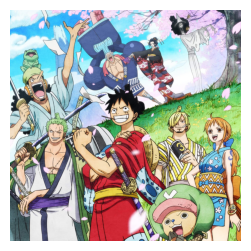

output_text:
 ### 动漫推测：
这张图片看起来像是《海贼王》（One Piece）的一部分。《海贼王》是一部非常受欢迎的日本漫画和动画系列，讲述了一群冒险家在海上寻找宝藏的故事。

### 图片整体风格：
这张图片的风格是典型的《海贼王》风格，色彩鲜艳，充满活力。角色们穿着各种各样的服装，有的是传统的和服，有的则是现代的战斗装束。背景中有一些樱花花瓣飘落，增加了画面的美感。

### 图像中的细节：
1. **角色**：图片中有多个角色，包括主角蒙奇·D·路飞、索隆、娜美、乌索普、罗宾、弗兰奇和乔巴。他们看起来都很开心，似乎是在庆祝什么。
2. **动作**：角色们摆出各种姿势，有的跳跃，有的挥舞武器，显得非常兴奋。
3. **背景**：背景是一个有樱花树的场景，暗示这是一个春天的季节。樱花的飘落为画面增添了一种浪漫和宁静的感觉。

### 可能的背景故事：
根据图片中的信息，这可能是《海贼王》中的某个重要事件或节日。角色们看起来非常开心，可能是因为他们取得了重要的成就，或者是在庆祝某个特别的日子。樱花的飘落也暗示了这是一个美好的时刻，可能与角色们的友情或团队精神有关。


In [10]:
# 可以自己定义一些图像分析prompt，例如：
## 动漫分析
image_file="PaddleMIX/applications/MULLM/examples/haizeiwang.jpeg"
prompt = "请描述这个动漫图片，需要1. 推测动漫是哪一部；2. 给出图片的整体风格；3.描述图像中的细节，并推测可能的背景故事。"
visualize_image(image_file)
messages = definite_messages(image_file, prompt)
output_text = model_inference(messages)
print("output_text:\n", output_text[0])

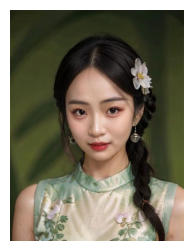

output_text:
 ```json
{
  "性别": "女性",
  "面相特征": {
    "美貌长相": "面容清秀，皮肤白皙，五官精致",
    "五官": {
      "眼睛": "双眼皮，眼眸明亮",
      "鼻子": "鼻梁挺拔",
      "嘴巴": "嘴唇饱满，微笑时露出洁白的牙齿",
      "耳朵": "佩戴银色耳环"
    },
    "表情": "表情温和，眼神温柔",
    "配饰": {
      "头发": "黑色长发，编成辫子，发间插有白色花朵",
      "服装": "穿着绿色旗袍，旗袍上有花卉图案"
    }
  }
}
```


In [11]:
# 可以自己定义一些图像分析prompt，例如：
## 人脸分析
image_file="PaddleMIX/applications/MULLM/examples/renxiang.JPG"
prompt = "请详细描述此人的性别，面相特征，包括美貌长相、五官、表情、配饰等细节，输出为JSON格式,中文。"
visualize_image(image_file)
messages = definite_messages(image_file, prompt)
output_text = model_inference(messages)
print("output_text:\n", output_text[0])

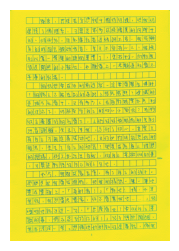

output_text:
 后来，即使在文理试中取得佳绩，但我们

读了管理系，算是众多成绩优异的同学中

的一个例外。自知当记者这条路不易，我托额

外的亲戚去面试工作，皇天不负有心人，我顺

利以第一名的头衔毕业了，更找到一份对我

很感兴趣的小报社，如愿踏上一名报道社会不

平事的记者。

谁说想要成功的前路就一定要通过律师师

？谁说人不能在别的道路上发光发热？遗憾的

是现今社会中，又有多少人在面对现实与名利

的洗礼下，仍能坚守自己的初心小庙呢？在物

欲主义盛行的社会下，人们往往被眼前的名利

冲昏头脑，失去了自我，忘却了初心。其实只

有自己才能定义成功吧，又何必汲汲于世俗的

眼光，丢失了自己的初衷？与其成为世人理想

的模样，倒不如活出自我，做自己喜欢做的事

，才算是对得起自己的人生吧。

如今，我都成家立室，有了自己的孩子。

他总是把我当作模板，把我的模样一模一样地

画在漫画上。「真好看！」「对吧！妈，如果

我说，我想当漫画家，你不反对我吧……」

妈妈他说出这一句，「怎么像呢？要做自己喜

欢的事，妈永远支持你啊！」儿子突然开朗，

我也浅浅一笑，想让他好好记住这句话，像我


In [12]:
# 可以自己定义一些图像分析prompt，例如：
## 繁体字识别
image_file="PaddleMIX/applications/MULLM/examples/doc_2.png"
prompt = "请识别图片中的繁体字，并转换为简体中文输出。格式要求和原文格式一致。输出简体字。"
visualize_image(image_file)
messages = definite_messages(image_file, prompt)
output_text = model_inference(messages)
print("output_text:\n", output_text[0])

#### 4. 模型拓展 Qwen2.5-VL
<img src="https://github.com/user-attachments/assets/b3a8d5f9-3611-4945-8056-e816593cf748" width="60%" alt="Qwen2-VL模型图">

Qwen2.5-VL在整体架构上没有太大变动，主要涉及以下两个改进：

* **时间和图像尺寸的感知**：在空间维度上，Qwen2.5-VL 不仅能够动态地将不同尺寸的图像转换为不同长度的 token，还直接使用图像的实际尺寸来表示检测框和点等坐标，而不进行传统的坐标归一化。这使得模型能够直接学习图像的尺度。在时间维度上，引入了动态 FPS (每秒帧数)训练和绝对时间编码，将 mRoPE id 直接与时间流速对齐。这使得模型能够通过时间维度 id 的间隔来学习时间的节奏。
* **更简洁高效的视觉编码器**：视觉编码器在多模态大模型中扮演着至关重要的角色。Qwen2.5-VL从头开始训练了一个原生动态分辨率的 ViT，包括 CLIP、视觉-语言模型对齐和端到端训练等阶段。为了解决多模态大模型在训练和测试阶段 ViT 负载不均衡的问题，Qwen2.5-VL引入了窗口注意力机制，有效减少了 ViT 端的计算负担。在Qwen2.5-VL的 ViT 设置中，只有四层是全注意力层，其余层使用窗口注意力。最大窗口大小为 8x8，小于 8x8 的区域不需要填充，而是保持原始尺度，确保模型保持原生分辨率。此外，为了简化整体网络结构，Qwen2.5-VL使 ViT 架构与 LLMs 更加一致，采用了 RMSNorm 和 SwiGLU 结构。



#### 5.环境配置
#### 模型fp16精度推理的显存开销，如果使用Qwen2.5-VL-72B模型，需要使用4卡40以上显存的GPU

| 模型                     | 图像理解显存占用|
|-------------------------|----------------|
| Qwen/Qwen2.5-VL-3B-Instruct|  16G       |      
| Qwen/Qwen2.5-VL-7B-Instruct|    22G       |      
| Qwen/Qwen2.5-VL-72B-Instruct|      4*42G       |         

#### 6. Qwen2.5-VL图像描述快速体验

需要重启下内核

In [1]:
import paddle

from paddlemix.models.qwen2_5_vl import MIXQwen2_5_Tokenizer
from paddlemix.models.qwen2_5_vl.modeling_qwen2_5_vl import Qwen2_5_VLForConditionalGeneration
from paddlemix.processors.qwen2_5_vl_processing import (
    Qwen2_5_VLImageProcessor,
    Qwen2_5_VLProcessor,
    process_vision_info,
)
from paddlemix.utils.log import logger

/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/paddle/utils/cpp_extension/extension_utils.py:686: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/_distutils_hack/__init__.py:31: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
[

import module error: fast_ln
import module error: fused_ln
Warning, FusedLn module is not available, use LayerNorm instead.
Warning, FusedLn module is not available, use LayerNorm instead.


(…)lama-3-8B-Instruct/tokenizer_config.json: 100%|██████████| 51.1k/51.1k [00:00<00:00, 78.4MB/s]
(…)Meta-Llama-3-8B-Instruct/tokenizer.model: 100%|██████████| 2.18M/2.18M [00:00<00:00, 323MB/s]
(…)ma-3-8B-Instruct/special_tokens_map.json: 100%|██████████| 73.0/73.0 [00:00<00:00, 410kB/s]
[2025-02-24 12:14:33,964] [ WARNING] moe_lm.py:454 - `grouped_gemm` is not installed, using sequential GEMM, which is slower.


modeling_internlm2 has_flash_attn is True.
modeling_intern_vit has_flash_attn is True.


In [ ]:
# 下载模型权重，定义模型
model_path = "Qwen/Qwen2.5-VL-3B-Instruct" #入门推荐使用3B模型，7B加载模型需等待较长时间
# model_path = "Qwen/Qwen2.5-VL-7B-Instruct"
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(model_path, dtype="float16", attn_implementation="eager")
image_processor = Qwen2_5_VLImageProcessor()
tokenizer = MIXQwen2_5_Tokenizer.from_pretrained(model_path)
processor = Qwen2_5_VLProcessor(image_processor, tokenizer)

# 推理大图时，若显存不够，可以传入max_pixels参数
# min_pixels = 256*28*28 # 200704
# max_pixels = 1280*28*28 # 1003520
# processor = Qwen2_5_VLProcessor(image_processor, tokenizer, min_pixels=min_pixels, max_pixels=max_pixels)

In [ ]:
def visualize_image(image_path):
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img = mpimg.imread(image_path)
    plt.figure(figsize=(4, 3))  # 例如 4x3 英寸
    plt.imshow(img)
    plt.axis('off')  # 不显示坐标轴
    plt.show()

In [ ]:
def definite_messages(image_file, prompt):
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": f"{image_file}",
                },
                {"type": "text", "text": f"{prompt}"},
            ],
        }
    ]
    return messages

In [ ]:
# 模型推理
def model_inference(messages, max_new_tokens=512, temperature=0.6, top_p=0.8):
    image_inputs, video_inputs = process_vision_info(messages)
    text = [processor.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)]

    inputs = processor(
        text=text,
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pd",
    )
    generated_ids = model.generate(
        **inputs, max_new_tokens=max_new_tokens, temperature=temperature, top_p=top_p
    )  
    output_text = processor.batch_decode(
        generated_ids[0], skip_special_tokens=True, clean_up_tokenization_spaces=False
    )
    return output_text

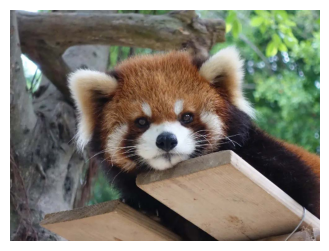

W0224 12:24:26.215711 25347 multiply_fwd_func.cc:76] got different data type, run type promotion automatically, this may cause data type been changed.


output_text:
 The image depicts a small, fluffy animal with distinctive reddish-brown fur and white markings on its face and chest. This animal is likely a red panda, also known as the lesser panda or Ailurus fulgens. The red panda has large, rounded ears, a bushy tail, and a long, slender body. Its eyes are dark and expressive, giving it a curious and endearing appearance.

In the background, there is a natural setting with green foliage, indicating that the red panda is in a forested area. The animal is perched on a wooden structure, possibly a platform or a tree branch, which suggests that it is in a zoo or a wildlife sanctuary. The wooden structure appears to be part of an enclosure designed to mimic the animal's natural habitat.

The red panda's fur is thick and dense, providing insulation against the cold temperatures found in its native habitat, which includes the forests of southwestern China, Bhutan, and India. These animals are known for their agility and are excellent climbe

In [8]:
image_file = "PaddleMIX/paddlemix/demo_images/examples_image1.jpg"
prompt = "Describe this image."

visualize_image(image_file)

messages = definite_messages(image_file, prompt)
output_text = model_inference(messages)
print("output_text:\n", output_text[0])



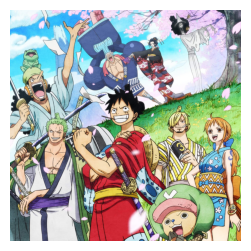

output_text:
 这张图片展示了一群穿着和服的角色，背景中有樱花树和蓝天白云，整体风格充满了日本传统元素和冒险气息。

### 1. 推测动漫是哪一部

根据角色的服装和背景，这张图片很可能来自《海贼王》（One Piece）系列。特别是图中的人物和他们的服装风格，与《海贼王》中的许多场景非常相似。

### 2. 图片的整体风格

图片的整体风格充满了日本传统和冒险的气息。角色们穿着和服，背景中有樱花树和蓝天白云，给人一种清新、明亮的感觉。这种风格通常出现在《海贼王》中的某些章节或场景中，尤其是那些描绘自然风光和角色们在海边或岛屿上的冒险经历。

### 3. 描述图像中的细节，并推测可能的背景故事

- **人物**：图片中有多个角色，包括一个穿着红色和服、手持武器的角色，可能是主角路飞；另一个穿着绿色和服、手持武器的角色，可能是索隆；还有其他几位穿着不同颜色和服的角色，可能是其他主要成员。
- **细节**：角色们的表情各异，有的微笑，有的严肃，显示出他们各自的性格特点。背景中的樱花树和蓝天白云增加了画面的美感，暗示这是一个充满希望和冒险的场景。
- **背景故事**：这张图片可能描绘的是《海贼王》中的某个重要事件，比如一次重要的战斗前的准备，或者是角色们在海边的休息时刻。樱花树和蓝天白云的背景可能象征着新的开始或希望，而角色们的服装和表情则反映了他们在面对挑战时的不同态度和情感。

总的来说，这张图片通过其独特的视觉元素和角色设计，成功地传达了《海贼王》系列特有的冒险和探索精神。


In [9]:
# 可以自己定义一些图像分析prompt，例如：
## 动漫分析
image_file="PaddleMIX/applications/MULLM/examples/haizeiwang.jpeg"
prompt = "请描述这个动漫图片，需要1. 推测动漫是哪一部；2. 给出图片的整体风格；3.描述图像中的细节，并推测可能的背景故事。"
visualize_image(image_file)
messages = definite_messages(image_file, prompt)
output_text = model_inference(messages)
print("output_text:\n", output_text[0])

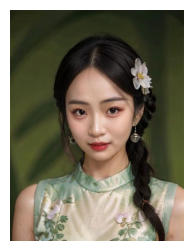

output_text:
 ```json
{
  "性别": "女性",
  "面相特征": {
    "头发": "黑色长发，编成辫子并用白色花朵装饰",
    "眼睛": "大而明亮，带有红色眼影",
    "鼻子": "挺拔且匀称",
    "嘴巴": "红唇，微笑时露出牙齿",
    "耳朵": "佩戴银色耳环"
  },
  "服饰": {
    "上衣": "绿色旗袍，上有花卉图案"
  }
}
```


In [10]:
# 可以自己定义一些图像分析prompt，例如：
## 人脸分析
image_file="PaddleMIX/applications/MULLM/examples/renxiang.JPG"
prompt = "请详细描述此人的性别，面相特征，包括美貌长相、五官、表情、配饰等细节，输出为JSON格式,中文。"
visualize_image(image_file)
messages = definite_messages(image_file, prompt)
output_text = model_inference(messages)
print("output_text:\n", output_text[0])

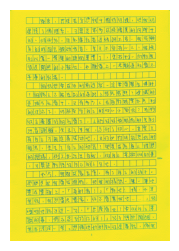

output_text:
 后来，即使在文思试中成绩很烂，但我们还是读了修理系，可算是最多成绩惨烈的同学中的一份例外。直到记者这阵路不易，我花额外的时间去钻研我习，皇天不负有心人，我顺利以第一荣誉的头衔罩着了，又找到一份对我很是照顾的小报社，如愿当上一名报道社会不平事的记者。

话说想要成功的话就一定要管医生健肝？话说人不能在别的道路上强光发热？遗憾的是现今社会中，又有多少人在面对现实和急利的洪流下，仍能坚守自己的初心小猫呢？在的欲主义盛行的社会下，人们往往被眼前的名利冲昏头脑，失去了自我，忘却了初心。其实只有自己才能定義成功吧，又何必拘泥於世俗的眼光，丢去了自己的初衷？与其成为身人理想的模樣，倒不如活出自我，做自己尊敬的事，才算是對得任自己的人生吧。

如今，我都成家立室，有了自己的孩子。他总是把我当成模特，把我的样貌一笔一划地画在画板上。「真好看！」「好吧！妈，儿子我说，我想留久点家，你不会骂我吧……」兒子咽咽地说出这一句。「怎麽偷忙？要做自己尊敬的事，妈永远支持你的！」儿子突然开朗，我也浅笑一笑。想讓他好好記住這番話，像我


In [11]:
# 可以自己定义一些图像分析prompt，例如：
## 繁体字识别
image_file="PaddleMIX/applications/MULLM/examples/doc_2.png"
prompt = "请识别图片中的繁体字，并转换为简体中文输出。格式要求和原文格式一致。输出简体字。"
visualize_image(image_file)
messages = definite_messages(image_file, prompt)
output_text = model_inference(messages)
print("output_text:\n", output_text[0])

请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 